In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re
import scipy
import numpy as np
import os
# set editable pdf font
plt.rcParams['pdf.fonttype'] = 42

In [2]:
out = '../results/BindingPotentialReporterAssayScoring/'
os.makedirs(out, exist_ok=True)

# Functions

In [3]:
def mask_sequences(text, sequences):
    masked_text = text
    # Create a regular expression pattern to match any of the sequences
    for s in sequences:
        masked_text = re.sub(s, 'N' * len(s), masked_text)
    return masked_text

def ProcessZscores(rbnsZscores, p):
    # Get p-values for each motif from z-scores
    df = pd.DataFrame()
    df['zscore'] = rbnsZscores
    df['pval'] = scipy.special.ndtr(-rbnsZscores)
    # Keep only significantly enriched motifs p-val < 0.05, tailed test
    dfSign = df.loc[df.pval < p].copy()
    return dfSign

def ScoreSequence(text, rbnsZscores, p=0.05):
    # Process zscores
    dfSign = ProcessZscores(rbnsZscores, p)
    # Split the sequence into 5mers
    kmers = [text[i:i+5] for i in range(0, len(text)-4)]
    # Keep only kmers that are in significant motifs, and count them
    kmers = pd.Series([k for k in kmers if k in dfSign.index])
    # Count the number of times each kmer appears
    dfQuant = kmers.value_counts().to_frame()
    # Add corresponding k-mer z-score to the count
    dfQuant = dfQuant.merge(dfSign, left_index=True, right_index=True, how='left')
    # Calculate the score by multipying the count by the z-score
    dfQuant['seqScore'] = dfQuant['count'] * dfQuant.zscore
    # Sum the scores to get a fragment score
    score = dfQuant.seqScore.sum()
    return score

# Data

5 nM       1049.1448
80 nM      1031.3658
1300 nM    1015.8423
dtype: float64
Most enriched concentration for TRA2B:  5 nM


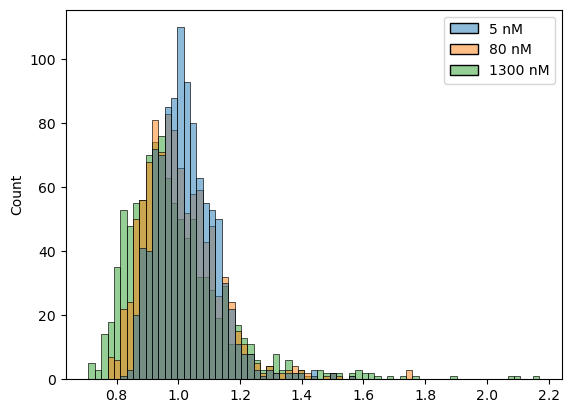

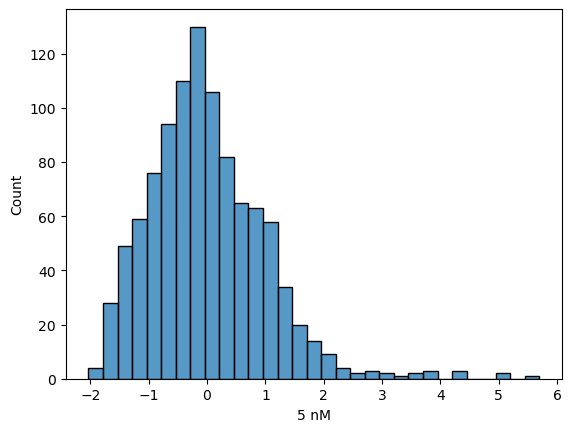

In [4]:
# Load data
# RBNS motifs - datasets enlisted in the supplementary data of: Van Nostrand, E.L. et al. (2020) ‘A large-scale binding and functional map of human RNA-binding proteins’, Nature, 583(7818), pp. 711–719.
rbns = pd.read_csv('../data/InVitroMotifEnrichment/RNA-Bind-N-Seq_5mer_z-scores.csv', index_col=0, sep=';')
rbns.index = rbns.index.str.replace('U', 'T')


# TRA2B RBNS motifs, obtained from ENCODE - value represents frequency of motif in enriched library vs in the input library
tra2b = pd.read_csv('../data/InVitroMotifEnrichment/RBNS_TRA2B/ENCFF083WIC_5mers.tsv', index_col=0, sep='\t')

# Process TRA2B data
# Sum up the R values to determine the most enriched protein concentration
tra2bRsum = tra2b.sum(axis=0).sort_values(ascending=False)
print(tra2bRsum)
conc = tra2bRsum.index.tolist()[0]
print('Most enriched concentration for TRA2B: ', conc)
# Convert the R values to Z scores
tra2bZ = tra2b[conc].copy()
m = tra2bZ.mean()
s = tra2bZ.std()
tra2bZ = tra2bZ.apply(lambda x: (x - m) / s)
sns.histplot(tra2b)
plt.show()
sns.histplot(tra2bZ)
plt.show()

# Add TRA2B data to the RBNS motifs
rbns['TRA2B'] = tra2bZ

# Reporter nuc / cyto ratios, obtained from the preprint supplementary data, apply log2 transformation
readouts = pd.read_excel('../data/ReporterAssay/targeted-seq.xlsx', sheet_name='dox_timepoints')
readouts['log2_nc_ratio'] = readouts['nc_ratio'].apply(lambda x: np.log2(x))

# Fragment sequences, obtained from the preprint supplementary data
fragments = pd.read_excel('../data/ReporterAssay/reporterassay.xlsx', sheet_name='Ordered_fragments')
# Masking sequences - overlaps for gibbson assembly, UTRs and introns
mask = pd.read_csv('../data/ReporterAssay/MaskingSequences.tsv', sep='\t')
# Make sequences uppercase
mask['Sequence'] = mask['Sequence'].str.upper()
fragments['bases'] = fragments['bases'].str.upper()

In [5]:
# Print the number of proteins in RBNS data
print('Number of proteins in RBNS data: ', rbns.shape[1])

Number of proteins in RBNS data:  79


In [6]:
dfExample = ProcessZscores(tra2bZ, p=0.05).sort_values(by='zscore', ascending=False)
dfExample.head()

,zscore,pval
[TRA2B_0nM],,
GCCCG,5.695029,6.167560e-09
ACCCG,5.025935,2.504923e-07
CCCGA,5.024896,2.518522e-07
GAAGA,4.366193,6.321547e-06
CACCC,4.310089,8.159457e-06


In [7]:
# Define sequences to score for each fragment
fragments['frag_order'] = fragments['name'].apply(lambda x: int(x.split('_')[-1]))
fragments['intron'] = fragments['name'].apply(lambda x: False if '_NoIn_' in x else True)
fragments['MV_optimised'] = fragments['name'].apply(lambda x: False if '_DeO_' in x else True)
fragments.head()

,name,bases,frag_order,intron,MV_optimised
0,PPIG_DeO_NoIn_1,GGAAAAGGATGACAAGTATAAAAACAAAGAGCTACGTTACGCGAGT...,1,False,False
1,PPIG_DeO_NoIn_2,AAGTGGGAGCGGGTCATGAACTTCGAGGATGGGGGCGCAGTGACGG...,2,False,False
2,PPIG_DeO_NoIn_3,TCTACAGAGCGCCTTTACCCCGAGGATGGCGTCCTTAAGGGGGATA...,3,False,False
3,PPIG_DeO_NoIn_4,ACTGGCGGGATGGATGAGCTTTACAAGGGCGGCGGCGGAGGCAGCG...,4,False,False
4,PPIG_DeO_NoIn_5,GAAAAGGATGACAAGTATAAAAACAAAGTCAAAAAGCGAGCCAAAT...,5,False,False


In [8]:
# Mask overlaps and overlaps+introns
for key, df in {'masked_OverlUtrsIntr': mask}.items():
    mask_seqs = df['Sequence'].tolist()
    fragment_seqs = fragments['bases'].tolist()
    # Mask the sequences
    masked_seqs = [mask_sequences(seq, mask_seqs) for seq in fragment_seqs]
    fragments[key] = masked_seqs

In [9]:
# Make a dataframe of enriched motifs for all proteins
dfs = []
for protein in rbns.columns:
    df = ProcessZscores(rbns[protein], p=0.05).reset_index()
    df.rename(columns={'index': 'kmer'}, inplace=True)
    df['protein'] = protein
    dfs.append(df)
dfEnrichedKmers = pd.concat(dfs, ignore_index=True)
# Print how many enriched motifs are there for each protein
print(dfEnrichedKmers.groupby('protein').size().sort_values(ascending=True))
# Save the enriched motifs as source data
dfEnrichedKmers.to_csv(f'{out}SourceData_RBNS-EnrichedMotifs.csv', index=False)

protein
RBFOX3      13
CPEB1       19
RBM22       19
HNRNPCL1    19
HNRNPC      20
            ..
RBM45       80
IGF2BP2     82
SRSF5       82
RBM6        87
DAZAP1      88
Length: 79, dtype: int64


In [10]:
dfEnrichedKmers.head()

,kmer,zscore,pval,protein
0,AAAAT,3.136,8.563460e-04,A1CF
1,AAATA,2.545,5.463887e-03,A1CF
2,AAATC,2.552,5.355326e-03,A1CF
3,AAATT,4.529,2.963175e-06,A1CF
4,AATAA,5.409,3.168881e-08,A1CF


# Score binding potential for fragments, then score reporters as sum of fragments

In [11]:
# Score the masked sequences with the RBNS motifs
protScoringCols = []
protScores = []
for prot in rbns.columns:
    scoresOverlUtrsIntr = []
    # Scoring reporters, masking introns
    for seq in fragments['masked_OverlUtrsIntr'].values.tolist():
        scoresOverlUtrsIntr.append(ScoreSequence(seq, rbns[prot]))
    # Assign the scores to the fragments
    protScores.append(scoresOverlUtrsIntr)
    protScoringCols.append(prot + '_masked_OUI')
# Make a dataframe with the scores
dfBindPot = pd.DataFrame(protScores, index=protScoringCols, columns=fragments.index).T
dfBindPot.head()
# Concatenate the scores with the fragment data
fragments = pd.concat([fragments, dfBindPot], axis=1)
# Set name as index
fragments.set_index('name', inplace=True)

In [12]:
# Calculate the score for the assembly of different fragments
reporters = readouts[['structure', 'int_pattern']].drop_duplicates()
# Scores obtained with intron masking will be used to score reporters
scoreCols = [col for col in fragments.columns if col.endswith('masked_OUI')]

scores = []
for i, row in reporters.iterrows():
    codonOpt = row['structure'].split('-')
    intPattern = [x.strip('t') for x in row['int_pattern'].split('-')]
    order = [str(x) for x in range(1,9)]
    frags = []
    # Identify each fragment by its name
    for o, int, ord in zip(codonOpt, intPattern, order):
        frags.append(f'PPIG_{o}_{int}_{ord}')
    # Retrieve the scores for all fragments that make up the reporter and sum them
    scores.append(fragments.loc[frags, scoreCols].sum(axis=0))

In [13]:
# Make a dataframe of scores, with indexes matching the rows of the reporters table
dfScores = pd.DataFrame(scores, index=reporters.index)
# Clean the column names
proteinCols = [col.replace('_masked_OUI', '') for col in dfScores.columns]
dfScores.columns = proteinCols
# Add scores to the reporter table
reporters = reporters.merge(dfScores, left_index=True, right_index=True, how='left').drop_duplicates()
# Save as source data
reporters.to_csv(f'{out}SourceData_Reporters-CDSBindingPotential.tsv', sep='\t', index=False)
print(reporters.head())
# Merge reporter with readouts
readouts = readouts.merge(reporters, on=['structure', 'int_pattern'], how='left')

                          structure  \
0   Opt-Opt-Opt-DeO-DeO-Opt-DeO-DeO   
9   Opt-Opt-Opt-Opt-Opt-Opt-DeO-DeO   
18  Opt-Opt-DeO-DeO-Opt-Opt-Opt-DeO   
27  DeO-Opt-DeO-Opt-Opt-DeO-DeO-Opt   
36  DeO-Opt-DeO-Opt-Opt-Opt-DeO-Opt   

                                  int_pattern     A1CF    BOLL   CELF1  \
0       Int-NoInt-NoInt-Int-NoInt-Int-Int-Int  150.698  39.312  67.337   
9       NoInt-NoInt-Int-Int-Int-Int-Int-NoInt   93.416  35.634  66.480   
18      Int-NoInt-NoInt-NoInt-Int-Int-Int-Int  111.176  51.695  70.097   
27  NoInt-NoInt-NoInt-NoInt-Int-NoInt-Int-Int  120.817  46.921  84.648   
36          Int-NoInt-Int-Int-Int-Int-Int-Int   89.598  58.699  69.863   

      CNOT4   CPEB1     DAZ3   DAZAP1   EIF4G2  ...    TAF15   TARDBP    TIA1  \
0   257.719  13.879  109.521  195.278  191.944  ...  150.420  128.598  28.936   
9   307.626  12.167   94.016  170.185  146.503  ...  129.186  148.642  28.936   
18  311.070  14.623  147.194  183.586  134.883  ...  157.839  145.339  33.221

In [14]:
# Clean up fragment columns
renameDict = {k: k.replace('_masked_OUI', '') for k in fragments.columns}
fragments.rename(columns=renameDict, inplace=True)
# Save as source data
fragments.to_csv(f'{out}SourceData_ReporterFragments-CDSBindingPotential.tsv', sep='\t')
fragments.head()

,bases,frag_order,intron,MV_optimised,masked_OverlUtrsIntr,A1CF,BOLL,CELF1,CNOT4,CPEB1,...,TAF15,TARDBP,TIA1,TRA2A,TRNAU1AP,UNK,ZCRB1,ZFP36,ZNF326,TRA2B
name,,,,,,,,,,,,,,,,,,,,,
PPIG_DeO_NoIn_1,GGAAAAGGATGACAAGTATAAAAACAAAGAGCTACGTTACGCGAGT...,1,False,False,NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN...,29.956,20.200,19.876,39.447,28.666,...,60.978,27.906,19.230,45.339,28.142,1.830,11.925,0.000,27.145,36.213361
PPIG_DeO_NoIn_2,AAGTGGGAGCGGGTCATGAACTTCGAGGATGGGGGCGCAGTGACGG...,2,False,False,NNNNNNNNNNNNNNNNNNNNNNNNNNNNNTGGGGGCGCAGTGACGG...,14.102,10.591,4.292,31.129,0.000,...,38.454,10.513,1.973,35.301,5.020,3.361,2.257,2.297,36.823,10.397156
PPIG_DeO_NoIn_3,TCTACAGAGCGCCTTTACCCCGAGGATGGCGTCCTTAAGGGGGATA...,3,False,False,NNNNNNNNNNNNNNNNNNNNNNNNNNNNNCGTCCTTAAGGGGGATA...,11.902,15.113,23.604,40.615,2.456,...,27.652,6.346,7.767,54.446,11.873,1.732,31.562,21.793,40.233,34.815028
PPIG_DeO_NoIn_4,ACTGGCGGGATGGATGAGCTTTACAAGGGCGGCGGCGGAGGCAGCG...,4,False,False,NNNNNNNNNNNNNNNNNNNNNNNNNNNNGCGGCGGCGGAGGCAGCG...,31.519,3.678,8.627,0.000,1.712,...,50.971,6.173,0.000,82.250,4.937,20.987,15.439,0.000,22.913,13.894312
PPIG_DeO_NoIn_5,GAAAAGGATGACAAGTATAAAAACAAAGTCAAAAAGCGAGCCAAAT...,5,False,False,NNNNNNNNNNNNNNNNNNNNNNNNNNNNTCAAAAAGCGAGCCAAAT...,44.370,0.000,3.988,17.813,0.000,...,6.332,11.302,0.000,57.087,1.830,4.394,0.000,0.000,6.604,9.450773


# Find RBPs for which increased purine multivalency correlates with increased binding potential

        purine_multivalency
TRA2A              0.969405
TRA2B              0.954826
SRSF9              0.949649
SRSF11             0.941993
SRSF2              0.829762


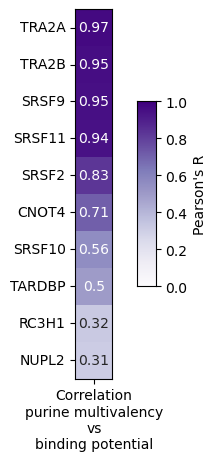

In [15]:
# Compute pearsons correlation with purine_multivalency
ReporterScores = readouts[['purine_multivalency']+ proteinCols].drop_duplicates()
dfPearson = ReporterScores.corr()
# Get only correlations with purine_multivalency
dfPearson = dfPearson.loc['purine_multivalency', proteinCols].to_frame().sort_values(by='purine_multivalency', ascending=False)
print(dfPearson.head())

# Plot top 10 hits, shrink cmap
g = sns.heatmap(dfPearson.head(10), annot=True, cmap='Purples', square=True, vmin=0, vmax=1, cbar_kws={'label': 'Pearson\'s R','shrink':.5, 'aspect': 10})
# Add black edge around the heatmap
for _, spine in g.spines.items():
    spine.set_visible(True)
    spine.set_color('black')
# Add black edge around the colorbar
cbar_ax = g.collections[0].colorbar.ax
for _, spine in cbar_ax.spines.items():
    spine.set_visible(True)
    spine.set_color('black')
# Rotate x-label
g.set_xticklabels(['Correlation\npurine multivalency\nvs\nbinding potential'])


# Save the plot
plt.savefig(f'{out}Figure_Top10-PearsonR-BindingPotential_PurineMV.pdf', bbox_inches='tight')
# Save the dataframe as source data
dfPearson.to_csv(f'{out}SourceData_PearsonR-BindingPotential_PurineMV.tsv', sep='\t')

In [16]:
# Top5 proteins
top5 = dfPearson.head().index.tolist()
top5

['TRA2A', 'TRA2B', 'SRSF9', 'SRSF11', 'SRSF2']

In [17]:
ReporterScores

,purine_multivalency,A1CF,BOLL,CELF1,CNOT4,CPEB1,DAZ3,DAZAP1,EIF4G2,ELAVL4,...,TAF15,TARDBP,TIA1,TRA2A,TRNAU1AP,UNK,ZCRB1,ZFP36,ZNF326,TRA2B
0,684.611962,150.698,39.312,67.337,257.719,13.879,109.521,195.278,191.944,32.329,...,150.420,128.598,28.936,793.403,52.244,115.891,52.644,37.115,212.797,292.321956
9,1074.227016,93.416,35.634,66.480,307.626,12.167,94.016,170.185,146.503,32.329,...,129.186,148.642,28.936,1139.351,47.420,112.107,37.205,37.115,229.335,421.328176
18,1120.766897,111.176,51.695,70.097,311.070,14.623,147.194,183.586,134.883,41.235,...,157.839,145.339,33.221,1271.061,50.161,102.701,64.106,59.877,196.466,503.403302
27,876.842361,120.817,46.921,84.648,243.598,38.767,110.071,154.159,186.000,39.031,...,193.354,144.377,35.541,851.619,47.360,121.791,59.927,32.898,194.302,335.475375
36,1011.690865,89.598,58.699,69.863,245.538,43.564,124.724,162.980,175.676,55.374,...,191.675,140.734,46.922,953.412,61.747,141.885,62.754,61.105,199.481,373.503921
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5094,623.491576,146.880,62.377,76.597,195.157,45.276,140.229,188.073,221.117,55.374,...,212.909,122.415,46.922,648.453,66.571,145.669,78.193,61.105,183.283,250.211431
5103,840.673764,132.878,39.921,68.298,269.535,35.175,77.414,136.056,193.563,41.243,...,173.472,136.202,40.444,916.962,60.449,80.490,42.972,37.115,193.904,334.397043
5112,876.842361,120.817,46.921,84.648,243.124,38.767,110.071,154.159,186.000,39.031,...,193.354,146.102,35.541,876.009,47.360,121.791,59.927,32.898,196.726,337.401615
5121,1149.388170,104.908,44.967,63.497,282.686,18.100,116.500,195.022,143.870,37.090,...,127.698,152.084,26.751,1191.694,52.161,148.758,47.682,37.419,259.633,422.781575


# Plot figures

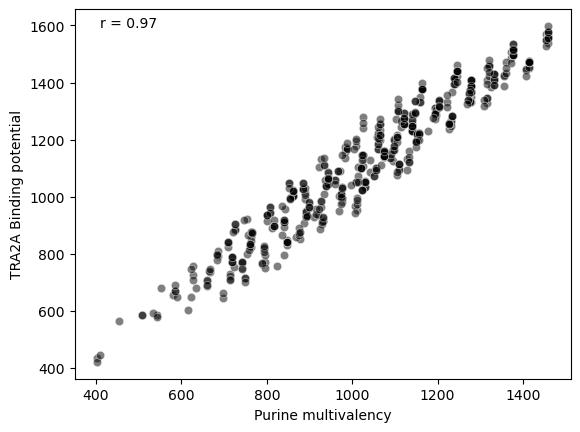

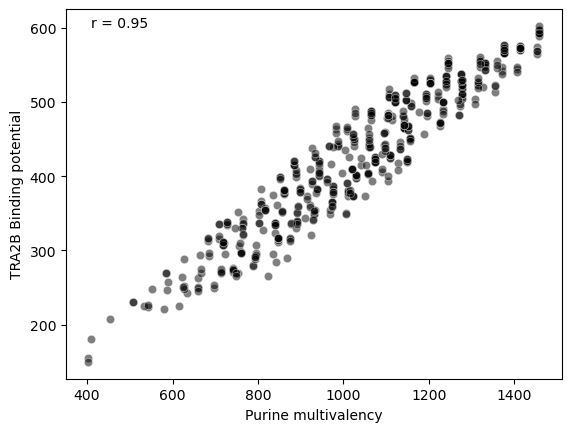

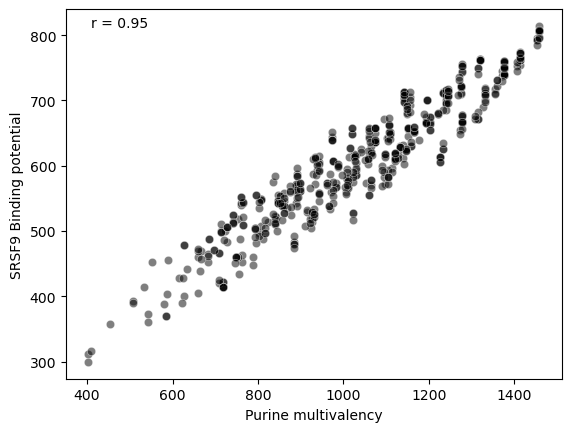

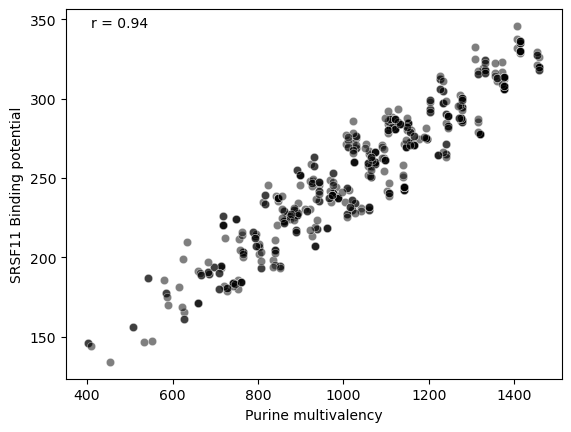

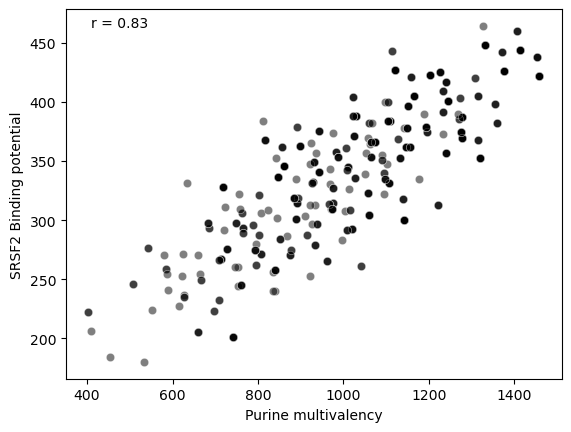

<Figure size 640x480 with 0 Axes>

In [18]:
# Plot scatterplots for top5 hits between purine_multivalency and binding potential
for prot in top5:
    g = sns.scatterplot(data=ReporterScores, x='purine_multivalency', y=prot, color='black', alpha=0.5)
    g.set_xlabel('Purine multivalency')
    g.set_ylabel(f'{prot} Binding potential')
    # Add pearson's R to the plot, relative coordinates
    g.text(0.05, 0.95, f'r = {dfPearson.loc[prot].values[0]:.2f}', transform=g.transAxes)
    plt.show()
    # Save the plot
    plt.savefig(f'{out}Figure_Scatter_{prot}-PurineMV.pdf', bbox_inches='tight')

In [19]:
# Save full readouts as source data
readouts.to_csv(f'{out}SourceData_ReporterNucRetentionAndScoring.tsv', sep='\t', index=False)

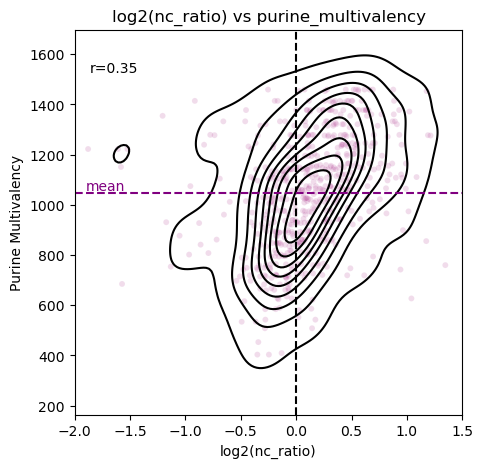

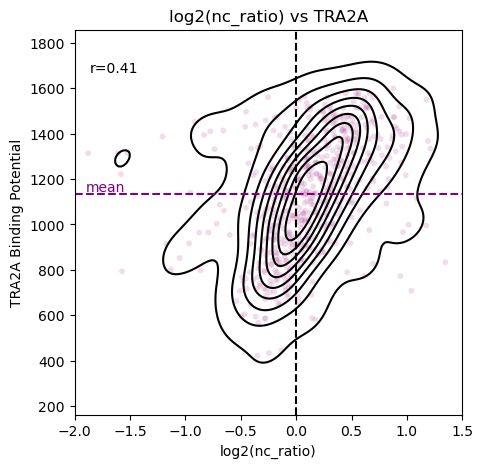

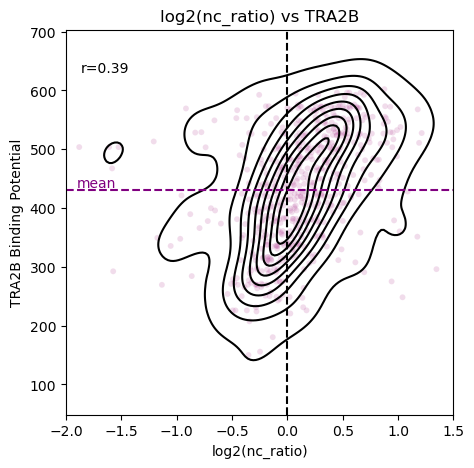

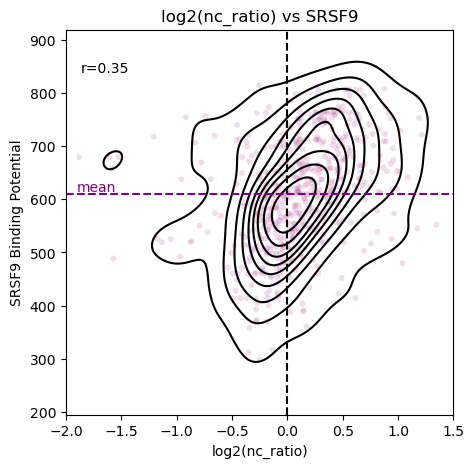

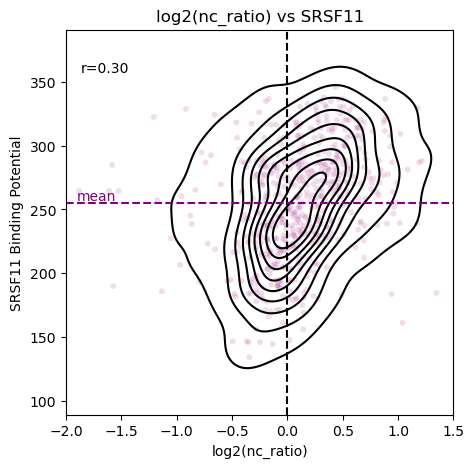

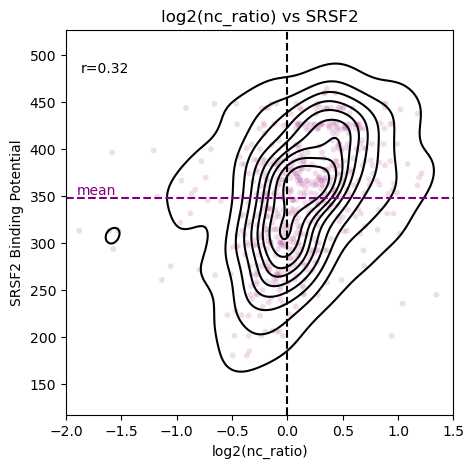

In [20]:
# Plot density log2FC(nc_ratio) vs  'purine_multivalency' and top 5 proteins
dfPlot = readouts.loc[readouts.time == '12h dox', ['bc_number', 'log2_nc_ratio', 'purine_multivalency'] + top5].copy()
# Get a mean log2_nc_ratio across replicates for the same barcodes
dfPlot = dfPlot.groupby(['bc_number']).mean().reset_index()
# Plot density plots in a loop
for col in dfPlot.columns[2:]:
    fig, ax = plt.subplots(1, 1, figsize=(5, 5))
    sns.scatterplot(data=dfPlot, x='log2_nc_ratio', y=col, ax=ax, size=3, alpha=0.2, color='#B9529F', legend=False)
    sns.kdeplot(data=dfPlot, x='log2_nc_ratio', y=col, ax=ax, fill=False, color='black', levels=10)
    plt.xlabel('log2(nc_ratio)')
    if col == 'purine_multivalency':
        plt.ylabel('Purine Multivalency')
    else:
        plt.ylabel(f'{col} Binding Potential')
    plt.title(f'log2(nc_ratio) vs {col}')
    # limit x-axis to -2
    plt.xlim(-2, 1.5)
    # Vertical line at 0
    plt.axvline(0, color='black', linestyle='--')
    # Horizontal line at mean BP/ MV
    plt.axhline(dfPlot[col].mean(), color='purple', linestyle='--')
    # Add Pearsons'r on the plot,use relative coordinates
    r = dfPlot['log2_nc_ratio'].corr(dfPlot[col])
    plt.text(0.1, 0.9, f'r={r:.2f}', horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)
    # Add text to mark the purple horizontal line, absolute coordinates
    plt.text(-1.9, dfPlot[col].mean(), f'mean', horizontalalignment='left', verticalalignment='bottom', color='purple')
    plt.show()
    # Save the plot
    fig.savefig(f'{out}Figure_BarcodeMeanLfcNucCyto_vs_{col}.pdf', bbox_inches='tight')